In [1]:
import pandas as pd 
import yfinance as yf

In [2]:
import plotly.express as px

In [4]:

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    # Calculate the short-term exponential moving average
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()

    # Calculate the long-term exponential moving average
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = short_ema - long_ema

    # Calculate the signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

def generate_signals(df):
    # Create a 'Position' column for signals (1 for Buy, -1 for Sell, 0 for Hold)
    df['Position'] = 0

    # Generate Buy signals
    df.loc[df['MACD'] > df['Signal_Line'], 'Position'] = 1

    # Generate Sell signals
    df.loc[df['MACD'] < df['Signal_Line'], 'Position'] = -1

def backtest_strategy(df, initial_balance=10000):
    balance = initial_balance
    position = 0

    # Iterate through the DataFrame to simulate trading
    for i in range(1, len(df)):
        if df['Position'][i] == 1 and df['Position'][i - 1] != 1:  # Buy signal
            position = balance / df['Close'][i]
            balance = 0
        elif df['Position'][i] == -1 and df['Position'][i - 1] != -1:  # Sell signal
            balance = position * df['Close'][i]
            position = 0

    # Calculate the final balance if still holding a position
    final_balance = balance + position * df['Close'].iloc[-1]

    return final_balance


In [5]:
# Example usage:
symbol = 'AAPL'
start_date = '2021-01-01'
end_date = '2022-01-01'

# Download historical stock data using yfinance
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Calculate MACD and signals
calculate_macd(stock_data)
generate_signals(stock_data)

# Print the DataFrame with MACD and signals
print(stock_data)

# Perform backtesting
final_balance = backtest_strategy(stock_data)
print(f"Final Portfolio Balance: ${final_balance:.2f}")

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-01-04  133.520004  133.610001  126.760002  129.410004  127.164162   
2021-01-05  128.889999  131.740005  128.429993  131.009995  128.736343   
2021-01-06  127.720001  131.050003  126.379997  126.599998  124.402931   
2021-01-07  128.360001  131.630005  127.860001  130.919998  128.647964   
2021-01-08  132.429993  132.630005  130.229996  132.050003  129.758362   
...                ...         ...         ...         ...         ...   
2021-12-27  177.089996  180.419998  177.070007  180.330002  178.292877   
2021-12-28  180.160004  181.330002  178.529999  179.289993  177.264587   
2021-12-29  179.330002  180.630005  178.139999  179.380005  177.353622   
2021-12-30  179.470001  180.570007  178.089996  178.199997  176.186935   
2021-12-31  178.089996  179.229996  177.259

<AxesSubplot:xlabel='Date'>

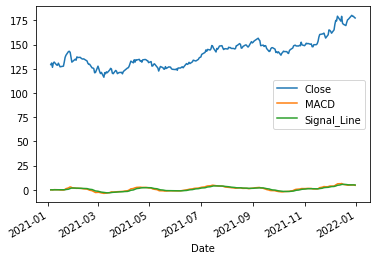

In [10]:
stock_data[['Close','MACD','Signal_Line']].plot()

In [12]:
fig = px.line(stock_data, x= stock_data.index, y='Close')
fig.show()

In [18]:
n_data = stock_data[['MACD','Signal_Line']]
fig = px.line(n_data, x=n_data.index ,y=n_data.columns)
fig.show()


In [5]:
# Fetch historical price data for TSLA from Yahoo Finance
def get_historical_data(symbol, start_date, end_date):
    tsla_data = yf.download(symbol, start=start_date, end=end_date)
    return tsla_data

# Calculate RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Generate Trading Signals
def generate_signals(rsi_values):
    signals = []
    for rsi in rsi_values:
        if rsi > 70:
            signals.append('SELL')
        elif rsi < 30:
            signals.append('BUY')
        else:
            signals.append('HOLD')
    return signals

In [6]:
# Example usage:
start_date = '2023-01-01'
end_date = '2023-07-20'
tsla_df = get_historical_data('TSLA', start_date, end_date)

# Calculate RSI and generate signals
rsi_values = calculate_rsi(tsla_df['Close'])
tsla_df['RSI'] = rsi_values
tsla_df['Signal'] = generate_signals(rsi_values)

[*********************100%***********************]  1 of 1 completed


In [7]:
def backtest_rsi(df,ib= 10000):
    balance = ib
    position = 0
    for i in range(len(df)):
        if df['Signal'][i] == 'BUY' and position == 0:
            print('Hey')
            position = balance / df['Close'][i]
            print(position)
            balance = 0
        elif df['Signal'][i] == 'SELL' and balance == 0:
            print('over here!')
            balance = position * df['Close'][i]
            position = 0

    final_balance = balance + (position * df['Close'][-1])

    return final_balance

In [9]:
# fig = px.line(stock_data, x= stock_data.index, y='Close')
# fig.show()

fig = px.line(tsla_df, x=tsla_df.index, y= 'Close')
fig.show()

In [11]:
fig = px.line(x=tsla_df.index, y=tsla_df.RSI)

# Add labels to axes
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Value',
    title='RSI Technical Indicator'
)

# Add dotted horizontal lines at 30 and 70
fig.add_shape(
    type='line',
    x0=tsla_df.index.min(),
    x1=tsla_df.index.max(),
    y0=30,
    y1=30,
    line=dict(color='red', dash='dash')
)

fig.add_shape(
    type='line',
    x0=tsla_df.index.min(),
    x1=tsla_df.index.max(),
    y0=70,
    y1=70,
    line=dict(color='red', dash='dash')
)

# Show the figure
fig.show()

In [12]:
def calculate_obv(df):
     # Calculate OBV
    df['Daily_Return'] = df['Close'].pct_change()
    df['Direction'] = df['Daily_Return'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    df['OBV'] = df['Direction'] * df['Volume']
    df['Cumulative_OBV'] = df['OBV'].cumsum()

def generate_obv_signals(df):
    df['Signal'] = 0  # 0 indicates no action
    df.loc[df['Cumulative_OBV'] > df['Cumulative_OBV'].shift(1), 'Signal'] = 1  # Buy signal
    df.loc[df['Cumulative_OBV'] < df['Cumulative_OBV'].shift(1), 'Signal'] = -1  # Sell signal

def backtest_obv(df,initial_balance):
    # Execute the strategy
    balance = initial_balance
    shares = 0

    for index, row in df.iterrows():
        if row['Signal'] == 1:  # Buy
            shares_to_buy = balance // row['Close']
            shares += shares_to_buy
            balance -= shares_to_buy * row['Close']
        elif row['Signal'] == -1:  # Sell
            balance += shares * row['Close']
            shares = 0

    # If there are remaining shares, sell them at the last price
    balance += shares * df.iloc[-1]['Close']

    return balance 

In [4]:
start_date = '2023-01-01'
end_date = '2023-07-20'
data = yf.download('TSLA',start=start_date,end=end_date)

[*********************100%***********************]  1 of 1 completed


In [7]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000
...,...,...,...,...,...,...
2023-07-13,274.589996,279.450012,270.600006,277.899994,277.899994,112681500
2023-07-14,277.010010,285.299988,276.309998,281.380005,281.380005,119771100
2023-07-17,286.630005,292.230011,283.570007,290.380005,290.380005,131569600


In [9]:
calculate_obv(data)
generate_obv_signals(data)

In [10]:
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Direction,OBV,Cumulative_OBV,Signal
Date,,,,,,,,,,,
2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800,NaN,0,0,0,0
2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000,0.051249,1,180389000,180389000,1
2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300,-0.029039,-1,-157986300,22402700,-1
2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100,0.024651,1,220911100,243313800,1
2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000,0.059349,1,190284000,433597800,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13,274.589996,279.450012,270.600006,277.899994,277.899994,112681500,0.021729,1,112681500,4516184700,1
2023-07-14,277.010010,285.299988,276.309998,281.380005,281.380005,119771100,0.012523,1,119771100,4635955800,1
2023-07-17,286.630005,292.230011,283.570007,290.380005,290.380005,131569600,0.031985,1,131569600,4767525400,1


In [13]:
backtest_obv(data,10000)

22028.0200881958

In [14]:
fig = px.line(data, x=data.index, y= 'Cumulative_OBV')
fig.show()